## Evaluating the Ring all-Reduce from scratch

This notebook has the goal of evaluating the performance of the ring all-reduce from scratch implementation. It will be compared to the built-in ring all-reduce implementation from the `torch.nn.parallel` module.

### Ring all-reduce from scratch

Ring all-reduce is a distributed algorithm that performes decentralized gradient synchronization. It performs the updates in the following way:

1. All the GPUs perform the same number of backprop iterations (in our case, one epoch). After they all complete, the sync starts.
2. Say the number of GPUs is `n`. Each GPU's gradient vector is split into `n` parts. Updating happens in two phases: share-reduce and share-only
3. Share-reduce: n-1 transfers happen. In the i-th transfer, GPU 1 sends it's first part of grad vector, GPU 2 sends second part, ... These parts are summed up and the result is sent to the next GPU. After n-1 transfers, each GPU has the sum of all the grad vectors for one part.

4. Share-only: Since each GPU has one one grad part fully summed up, they broadcast (share with all the others) that part of the gradient vector.

### Example:

4 GPUs (A, B, C, D) and 4 parts of the grad vector (1, 2, 3, 4):
A B C D

i=0:

A:send a0, rec d3
B:send b1, rec a0
C:send c2, rec b1
D:send d3, rec c2

i=1:

A: send a3+d3, rec c2+d2
B: send a0+b0, rec a3+d3
C: send b1+c1, rec a0+b0
D: send c2+d2, rec b1+c1

i = 2:

A: send a2+c2+d2, rec b1+c1+d1
B: send a3+b3+d3, rec a2+c2+d2
C: send a0+b0+c0, rec a3+b3+d3
D: send b1+c1+d1, rec a0+b0+c0

Share only:

A: broadcast a1+b1+c1+d1
B: broadcast a2+b2+c2+d2
C: broadcast a3+b3+c3+d3
D: broadcast a0+b0+c0+d0

A dataset of 1000 MNIST examples is used with mobilenet network, for simplicity and speed.

### Performance

Let's take a look at the performance of the ring all-reduce from scratch implementation. First let's import packages

In [1]:
import os
import time
import numpy as np
import pandas as pd
import os

In [4]:
logs_path = 'logs/'

In [15]:
acc_df = pd.read_csv(logs_path+'r_acc.csv')
loss_df = pd.read_csv(logs_path+'r_loss.csv')

acc_loss_df = pd.concat([acc_df, loss_df], axis=1)

Text(0.5, 0.98, 'Training of from-scratch implementation of Parameter Server')

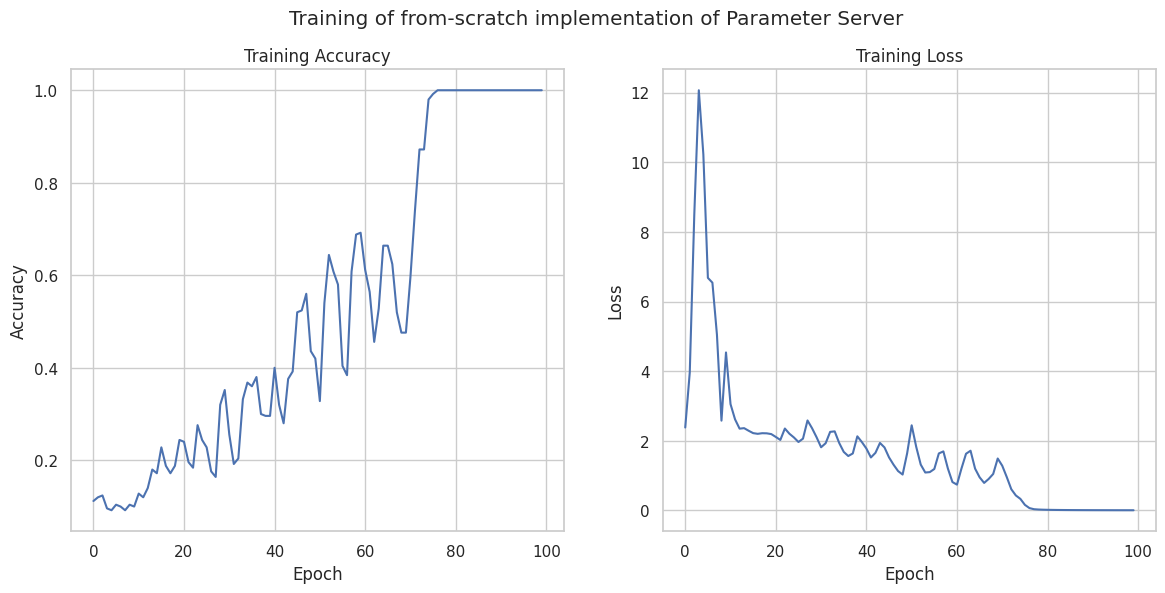

In [ ]:
# scatter the training accuracy and training time
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=acc_loss_df, x=acc_loss_df.index, y='acc')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=acc_loss_df, x=acc_loss_df.index, y='loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# subtitle
plt.suptitle('Training of from-scratch implementation of Ring all-reduce')


We can see that the model successfully achieves the 100% accuracy within 70-80 epochs (marginally better than from-scratch parameter server). Let's see how the performance compares to the built-in ring all-reduce implementation. 

In [24]:
b_acc_df = pd.read_csv(logs_path+'br_acc.csv')
b_loss_df = pd.read_csv(logs_path+'br_loss.csv')

b_acc_loss_df = pd.concat([b_acc_df, b_loss_df], axis=1)

Text(0.5, 0.98, 'Training of builtin implementation of Ring all-reduce')

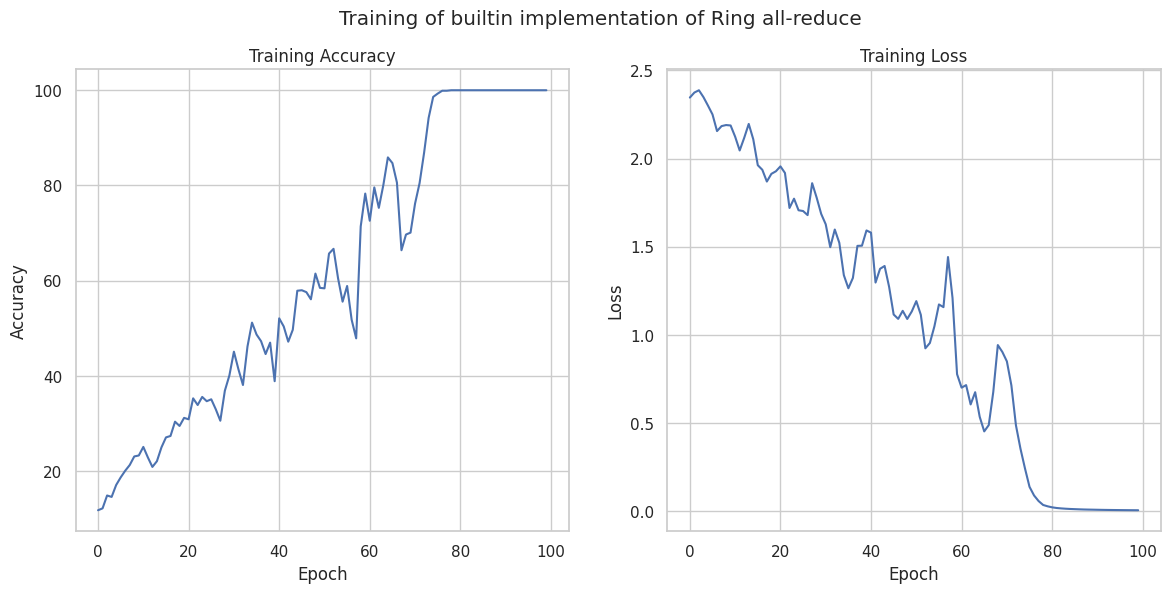

In [27]:
# scatter the training accuracy and training time
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=b_acc_loss_df, x=b_acc_loss_df.index, y='acc')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=b_acc_loss_df, x=b_acc_loss_df.index, y='loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# subtitle
plt.suptitle('Training of builtin implementation of Ring all-reduce')

We can see that the curve through epochs is very similar. One thing that cannot be seen from these graphs is the time taken for each epoch.

### Time taken for each epoch: From-scratch vs built-in

In [49]:
time_df = pd.read_csv(logs_path+'r_time.csv').rename(columns={'time': 'Time-From-Scratch'})
b_time_df = pd.read_csv(logs_path+'br_time.csv').rename(columns={'epoch_time': 'Time-Builtin'})
all_time_df = pd.concat([time_df, b_time_df], axis=1)

# make the difference
all_time_df['Time-From-Scratch'] = all_time_df['Time-From-Scratch'].diff().fillna(0)
all_time_df['Time-Builtin'] = all_time_df['Time-Builtin'].diff().fillna(0)

/tmp/ipykernel_4132852/2585468103.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=all_time_df, ci=None)


Text(0.5, 1.0, 'Epoch time: From-scratch vs Builtin')

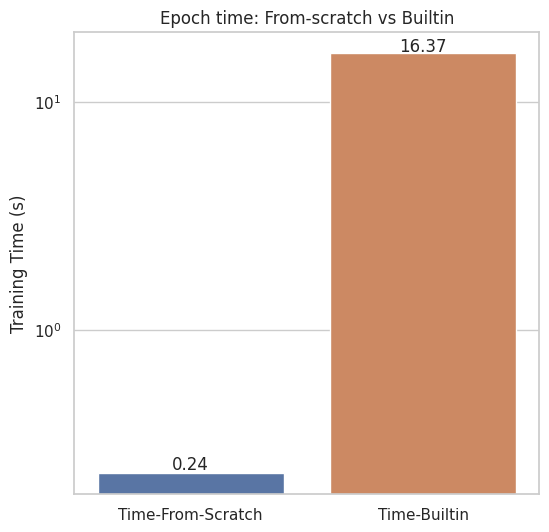

In [72]:
# barplot
plt.figure(figsize=(6, 6))

# barplot the means of columns
sns.barplot(data=all_time_df, ci=None)
plt.ylabel('Training Time (s)')
plt.yscale('log')

# plot the numbers on bars

plt.text(0, all_time_df['Time-From-Scratch'].mean() + 0.008, round(all_time_df.iloc[-1, 0], 2), ha='center')
plt.text(1, all_time_df['Time-Builtin'].mean() + 0.18, round(all_time_df.iloc[-1, 1], 2), ha='center')

plt.title('Epoch time: From-scratch vs Builtin')

We can see that the from-scratch implementation is ~70x faster than the builtin implementation. This is a very unexpected result. By further analysis we can see the biggest bottleneck in builtin implementation - data loading. Data loading has a relatively constant overhead per epoch, and therefore using the small dataset of 1000 examples is a bad use case for the builtin implementation. Let's visualize it:

### Built-in implementation - data loading overhead as function of dataset size

Text(0.5, 1.0, 'Data loading time for different training data sizes')

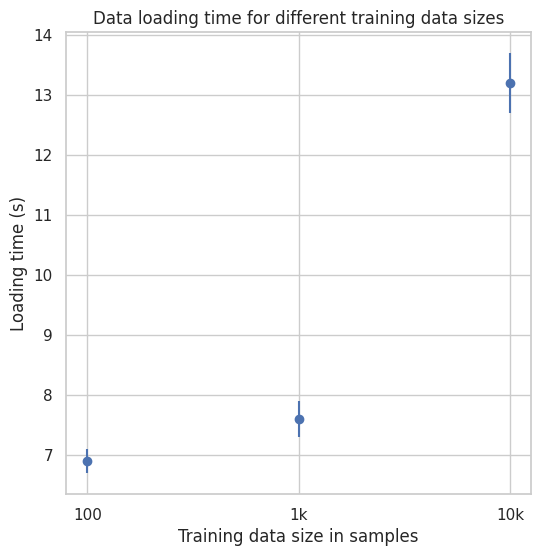

In [ ]:
loading_100_avg = 6.9
loading_100_std = 0.2

loading_1k_avg = 7.6
loading_1k_std = 0.3

loading_10k_avg = 13.2
loading_10k_std = 0.5

plt.figure(figsize=(6, 6))
plt.errorbar([0, 1, 2], [loading_100_avg, loading_1k_avg, loading_10k_avg], yerr=[loading_100_std, loading_1k_std, loading_10k_std], fmt='o')
plt.xticks([0, 1, 2], ['100', '1k', '10k'])
plt.xlabel('Training data size in samples')
plt.ylabel('Loading time (s)')
plt.title('Data loading time for different training data sizes')



We can see that even when using a small dataset of 100 samples, the data loading overhead is allmost the same as when using 10x more samples. By increasing the dataset size from 100 to 10k, laoding time only increased ~2x.

Therefore, we can deduce that for smaller datasets, our **from-scratch implementation is preferred over builtin DistributedDataParallel one**.